In [17]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [18]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [19]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


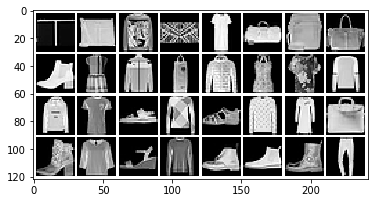

torch.Size([32, 1, 28, 28])


In [20]:
### LOAD DATA ###
dataset = 'fashion'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [21]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("/home/shared/phase-retrieval/models/VAE_Fashion/FC-VAE128Fashion_3.sd"));

Version 4


In [22]:
### Hand Paper (adapted) ###

def calc_meas(x):
    m = A.shape[1]
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    return torch.abs(compressed)

def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_meas,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

In [23]:
m = 10 # 10, 25, 50, 100, 200, 300, 500, 784

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

torch.Size([784, 10])


Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


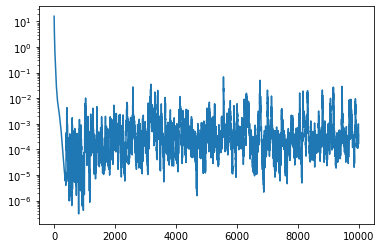

In [24]:
### Test one sample A measurements ###

num_batches = 32
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)


for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_measurements = calc_meas(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_measurements, vae=vae, device=device,
                                                        measurement_fn=calc_meas, z_shape=(latent_dim, ),
                                                        optim_lr=optim_lr, max_steps=max_steps, max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()
        
        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [25]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_Fashion/Ameas10_original_3_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_Fashion/Ameas10_3_1024.p", "wb"))

In [26]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_Fashion/Ameas10_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_Fashion/Ameas10_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


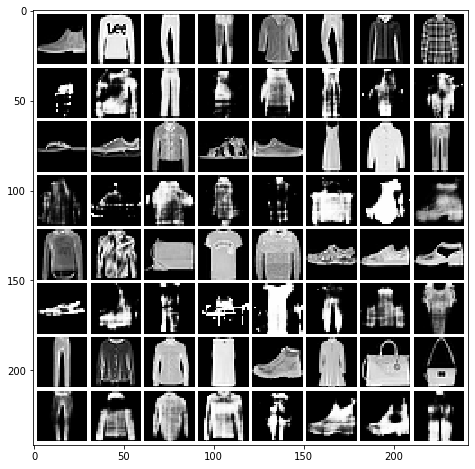

Signal error:
  MSE: 0.1577943912265546, std: 0.07776805302380538
  MAE: 0.24896388720514218, std: 0.08571655024236778
  SSIM: 0.16714348112078733, std: 0.1525065522741271
  FASI-MSE: 0.1580933096374163, std: 0.08311279252762473
  FASI-MAE: 0.250719631778023, std: 0.09321031655214547
  COCO-MSE: 0.12812487875478024, std: 0.06373283591520258

Magnitude error:
  MSE Magnitude: 51.83268004424982, std: 32.858542429232344

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [27]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
           
plot_grid(to_plot, figsize=(8, 8), file="../out/vae/fashion/{0}{1}.png".format('Ameas10_3_1024_', time.strftime("%Y%m%d_%H%M%S")))
#plot_grid(to_plot, figsize=(8, 8))


benchmark(pred=out_results, true=out_original, check_all=True)

## Test A measurements random init (1024 samples)

For small m small lr would be better for reducing mse error, but 1e-1 still reduces the measurement error best

| Nr Type | iterations | restarts | lr | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | 10000 | 3 | 1e-1 | 784 | 0.005362 | 0.03637 | 0.8768 | 0.005378 | 0.03640 | 0.005340 | 2.092
| 2 | 10000 | 3 | 1e-1 | 500 | 0.005816 | 0.03786 | 0.8686 | 0.005845 | 0.03791 | 0.005801 | 2.183
| 2 | 10000 | 3 | 1e-1 | 300 | 0.007228 | 0.04129 | 0.8520 | 0.007200 | 0.04129 | 0.007148 | 2.587
| 2 | 10000 | 3 | 1e-1 | 200 | 0.01409 | 0.05309 | 0.8006 | 0.01497 | 0.05428 | 0.01332 | 4.504
| 2 | 10000 | 3 | 1e-1 | 100 | 0.03719 | 0.09110 | 0.6467 | 0.04236 | 0.09725 | 0.03468 | 10.97
| 2 | 10000 | 3 | 1e-1 | 50 | 0.09797 | 0.1763 | 0.3592 | 0.1085 | 0.1886 | 0.08734 | 29.66
| 2 | 10000 | 3 | 1e-1 | 25 | 0.14427 | 0.2331 | 0.2090 | 0.1562 | 0.2480 | 0.1226 | 47.07
| 2 | 10000 | 3 | 1e-1 | 10 | 0.1578 | 0.2490 | 0.1671 | 0.1581 | 0.2507 | 0.1281 | 51.83


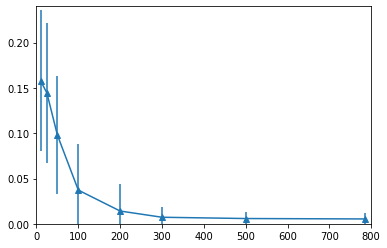

In [29]:
mse = [0.005362, 0.005815, 0.007228, 0.01409, 0.03719, 0.09797, 0.1443, 0.1578]
m = [784, 500, 300, 200, 100, 50, 25, 10]
std = [ 0.006341,  0.006732, 0.01100,  0.02997,  0.05100, 0.06553, 0.07700, 0.07777]

axes = plt.gca()
axes.set_xlim([0, 800])
axes.set_ylim([0, 0.24])
plt.errorbar(m, mse, std, marker='^')
plt.show()

### Raw outputs:

m=784:

Signal error:
  MSE: 0.005362721064333364, std: 0.006341121985913602
  MAE: 0.03637227483302521, std: 0.020665489324080678
  SSIM: 0.8768389480919582, std: 0.10191938195711646
  FASI-MSE: 0.005377823046679851, std: 0.006547068633825183
  FASI-MAE: 0.03639659232112276, std: 0.020885226860125946
  COCO-MSE: 0.005339999691738475, std: 0.006061213116860428

Magnitude error:
  MSE Magnitude: 2.0922899813657914, std: 2.4195276746378305


m=500:

Signal error:
  MSE: 0.005815830340532797, std: 0.006731962559708668
  MAE: 0.03786154474883938, std: 0.021867967151354247
  SSIM: 0.8686080016779438, std: 0.11208432268995676
  FASI-MSE: 0.005844540963700819, std: 0.007025257612072127
  FASI-MAE: 0.037911833574290676, std: 0.022121758492739573
  COCO-MSE: 0.005801159650432338, std: 0.006647088329082608

Magnitude error:
  MSE Magnitude: 2.1830012092046416, std: 2.5082620615891016


m=300:

Signal error:
  MSE: 0.007227758742978719, std: 0.01100349961643498
  MAE: 0.04129067896061328, std: 0.02579835835061976
  SSIM: 0.8519548418017946, std: 0.12978309885233283
  FASI-MSE: 0.007200251378491899, std: 0.010629165287783453
  FASI-MAE: 0.04128786599776493, std: 0.025652598896745822
  COCO-MSE: 0.00714767745154845, std: 0.010432102625618707

Magnitude error:
  MSE Magnitude: 2.5871547812289983, std: 3.9704328409044822


m=200:

Signal error:
  MSE: 0.014085765090237352, std: 0.029971378143206266
  MAE: 0.05308879290214217, std: 0.046264579973282274
  SSIM: 0.8006494368546317, std: 0.19604942424396096
  FASI-MSE: 0.014965074877732916, std: 0.03429503206608083
  FASI-MAE: 0.054283874847012026, std: 0.05088775737211136
  COCO-MSE: 0.013320626442176305, std: 0.026385986770902724

Magnitude error:
  MSE Magnitude: 4.503948838595408, std: 9.645433400355742


m=100:

Signal error:
  MSE: 0.03719262692564963, std: 0.05099944932411003
  MAE: 0.0910965485532016, std: 0.07128620544566704
  SSIM: 0.6467135720359384, std: 0.2690215387430673
  FASI-MSE: 0.042364529295627354, std: 0.0646893064488466
  FASI-MAE: 0.09724776191905168, std: 0.08487453020967903
  COCO-MSE: 0.034675324542952454, std: 0.04478611093351622

Magnitude error:
  MSE Magnitude: 10.971033917259728, std: 15.194655623593635


m=50:

Signal error:
  MSE: 0.09796617402341247, std: 0.06552890639199555
  MAE: 0.17630235053989418, std: 0.08081178703259508
  SSIM: 0.35922052139256744, std: 0.24173603533906377
  FASI-MSE: 0.10845936403902359, std: 0.07997392336672828
  FASI-MAE: 0.18862743258233072, std: 0.0965571268691422
  COCO-MSE: 0.08733721186054134, std: 0.05445645175533874

Magnitude error:
  MSE Magnitude: 29.65855430130918, std: 21.140709374505303


m=25:

Signal error:
  MSE: 0.14426896748800289, std: 0.07700054748863817
  MAE: 0.23308666965682726, std: 0.08489817353037003
  SSIM: 0.20898828845482548, std: 0.17216449367720046
  FASI-MSE: 0.15618616389126067, std: 0.08985448726632277
  FASI-MAE: 0.24803770563316535, std: 0.09892175163804592
  COCO-MSE: 0.12264349221344106, std: 0.06497293571692574

Magnitude error:
  MSE Magnitude: 47.06774878692735, std: 31.78494909632556


m=10:

Signal error:
  MSE: 0.1577943912265546, std: 0.07776805302380538
  MAE: 0.24896388720514218, std: 0.08571655024236778
  SSIM: 0.16714348112078733, std: 0.1525065522741271
  FASI-MSE: 0.1580933096374163, std: 0.08311279252762473
  FASI-MAE: 0.250719631778023, std: 0.09321031655214547
  COCO-MSE: 0.12812487875478024, std: 0.06373283591520258

Magnitude error:
  MSE Magnitude: 51.83268004424982, std: 32.858542429232344
